# VIF Critic Soft Ordinal Training Notebook

This notebook trains and evaluates the VIF Critic using **soft ordinal labels** with KL divergence loss.

**What is this model?**
- An MLP with classification output: 3 logits per dimension (one per class)
- Converts hard labels {-1, 0, +1} to soft probability distributions with ordinal smoothing
- Uses KL divergence loss between predicted softmax and soft targets
- Ordinal smoothing spreads mass to adjacent classes, so -1→0 errors cost less than -1→+1
- Input: State vector (text embeddings + time gaps + history EMA + user profile)
- Output: 10-dim alignment scores in {-1, 0, 1}

**Contents:**
1. Data Loading & Exploration
2. Model Architecture
3. Training Loop
4. Evaluation & Visualization
5. Ablation Studies

In [1]:
# Setup
import os
import sys
from pathlib import Path

notebook_dir = Path.cwd()
if notebook_dir.name == "critic_training":
    os.chdir(notebook_dir.parent.parent)
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import polars as pl
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")

Working directory: /Users/leongkaymei/Desktop/NUS-ISS/Capstone/twinkl
Using device: mps


## 1. Data Loading & Exploration

In [2]:
from src.vif.dataset import load_all_data, split_by_persona, merge_labels_and_entries

labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")

Labels: (740, 15)
Entries: (722, 8)
Unique personas: 102


In [3]:
from src.models.judge import SCHWARTZ_VALUE_ORDER

merged_df = merge_labels_and_entries(labels_df, entries_df)

print("Alignment value distribution per dimension:")
print("=" * 50)
for dim in SCHWARTZ_VALUE_ORDER:
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    counts = {v: (series == v).sum() for v in [-1, 0, 1]}
    print(f"{dim:15s}: -1={counts[-1]:3d}, 0={counts[0]:3d}, +1={counts[1]:3d}")

Alignment value distribution per dimension:
self_direction : -1=119, 0=328, +1=275
stimulation    : -1= 44, 0=582, +1= 96
hedonism       : -1= 89, 0=521, +1=112
achievement    : -1= 58, 0=453, +1=211
power          : -1= 65, 0=588, +1= 69
security       : -1=103, 0=487, +1=132
conformity     : -1= 96, 0=470, +1=156
tradition      : -1= 50, 0=520, +1=152
benevolence    : -1= 83, 0=350, +1=289
universalism   : -1=  5, 0=644, +1= 73


In [4]:
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=42)

print(f"Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)")
print(f"Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)")
print(f"Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)")

Train: 506 entries (70 personas)
Val:   106 entries (14 personas)
Test:  110 entries (16 personas)


## 2. Model Architecture

In [5]:
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.vif.critic_soft_ordinal import CriticMLPSoftOrdinal, soft_ordinal_loss_multi

text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")

state_encoder = StateEncoder(text_encoder, window_size=3, ema_alpha=0.3)
print(f"State dim: {state_encoder.state_dim}")

/Users/leongkaymei/Desktop/NUS-ISS/Capstone/twinkl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174


In [6]:
# Create model (Soft Ordinal: output 30 logits = 10 dims × 3 classes)
model = CriticMLPSoftOrdinal(
    input_dim=state_encoder.state_dim,
    hidden_dim=256,
    dropout=0.2,
)
model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(model)

Model parameters: 375,326
CriticMLPSoftOrdinal(
  (fc1): Linear(in_features=1174, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=256, out_features=30, bias=True)
  (gelu): GELU(approximate='none')
)


In [7]:
# Visualize soft ordinal targets
from src.vif.critic_soft_ordinal import make_soft_ordinal_targets

example_labels = torch.tensor([[-1, 0, 1]]).float()
soft = make_soft_ordinal_targets(example_labels, smoothing=0.15)

print("Soft ordinal targets (smoothing=0.15):")
for i, label in enumerate([-1, 0, 1]):
    probs = soft[0, i].numpy()
    print(f"  Label {label:+d} → [{probs[0]:.3f}, {probs[1]:.3f}, {probs[2]:.3f}]")

Soft ordinal targets (smoothing=0.15):
  Label -1 → [0.853, 0.128, 0.019]
  Label +0 → [0.115, 0.769, 0.115]
  Label +1 → [0.019, 0.128, 0.853]


## 3. Training Loop

In [8]:
from src.vif.dataset import VIFDataset
from torch.utils.data import DataLoader

print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s]

Train batches: 32
Val batches: 7
Test batches: 7


In [9]:
# Training setup (KL divergence with soft ordinal targets)
SMOOTHING = 0.15

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
)

history = {"train_loss": [], "val_loss": [], "lr": []}
checkpoint_path = "models/vif/notebook_soft_ordinal_best.pt"

In [10]:
# Training loop
n_epochs = 100
best_val_loss = float("inf")
patience_counter = 0
early_stop_patience = 20

print(f"Training (smoothing={SMOOTHING})...")
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = soft_ordinal_loss_multi(logits, batch_y, smoothing=SMOOTHING)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            val_loss += soft_ordinal_loss_multi(logits, batch_y, smoothing=SMOOTHING).item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)

    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]")
    else:
        patience_counter += 1
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}")

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f}")

Training (smoothing=0.15)...
Epoch   1: train=3.2532, val=2.8878, lr=0.001000 [BEST]
Epoch   2: train=2.4075, val=2.8011, lr=0.001000 [BEST]
Epoch   3: train=1.8471, val=2.7838, lr=0.001000 [BEST]
Epoch  11: train=0.3691, val=3.2996, lr=0.001000
Epoch  21: train=0.1959, val=3.1958, lr=0.000500
Early stopping at epoch 23

Best validation loss: 2.7838


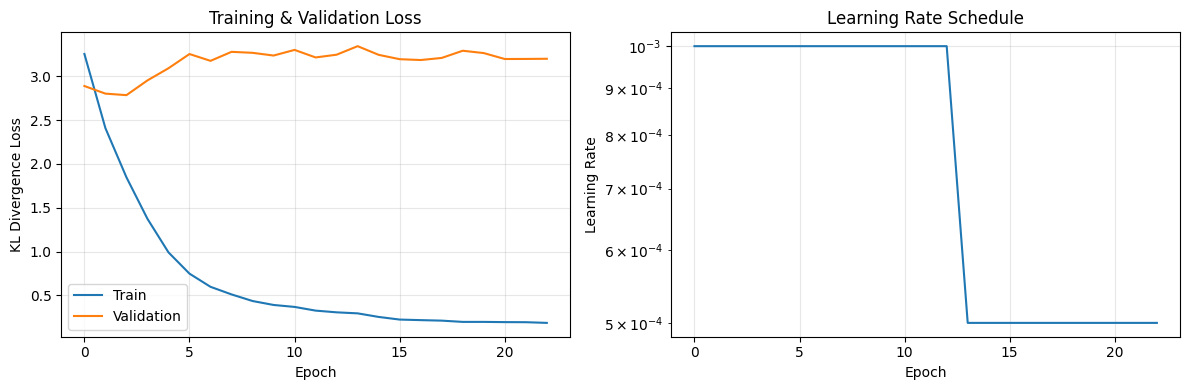

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("KL Divergence Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["lr"])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Learning Rate")
axes[1].set_title("Learning Rate Schedule")
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evaluation & Visualization

In [12]:
# Load best model and evaluate
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

from src.vif.eval import (
    compute_mae_per_dimension,
    compute_spearman_per_dimension,
    compute_accuracy_per_dimension,
    compute_qwk_per_dimension,
    format_results_table,
)

print("Evaluating on test set with Soft Ordinal predictions...")
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        pred = model.predict(batch_x)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(batch_y.numpy())

predictions = np.concatenate(all_preds, axis=0)
targets = np.concatenate(all_targets, axis=0)

mae_per_dim = compute_mae_per_dimension(predictions, targets)
spearman_per_dim = compute_spearman_per_dimension(predictions, targets)
accuracy_per_dim = compute_accuracy_per_dimension(predictions, targets)
qwk_per_dim = compute_qwk_per_dimension(predictions, targets)

results = {
    "predictions": predictions,
    "targets": targets,
    "mae_per_dim": mae_per_dim,
    "mae_mean": float(np.mean(list(mae_per_dim.values()))),
    "spearman_per_dim": spearman_per_dim,
    "spearman_mean": float(np.nanmean(list(spearman_per_dim.values()))),
    "accuracy_per_dim": accuracy_per_dim,
    "accuracy_mean": float(np.mean(list(accuracy_per_dim.values()))),
    "qwk_per_dim": qwk_per_dim,
    "qwk_mean": float(np.nanmean(list(qwk_per_dim.values()))),
}

print("\n" + format_results_table(results))

Evaluating on test set with Soft Ordinal predictions...

Dimension                   MAE   Spearman   Accuracy        QWK
----------------------------------------------------------------
self_direction           0.5182      0.279     56.36%      0.264
stimulation              0.2455      0.194     75.45%      0.071
hedonism                 0.1455      0.483     87.27%      0.439
achievement              0.3364      0.441     68.18%      0.397
power                    0.1545      0.556     85.45%      0.513
security                 0.3273      0.216     70.00%      0.176
conformity               0.4364      0.281     60.00%      0.265
tradition                0.2636      0.447     75.45%      0.402
benevolence              0.4273      0.156     66.36%      0.154
universalism             0.0455      0.403     95.45%      0.278
----------------------------------------------------------------
MEAN                     0.2900      0.346     74.00%      0.296


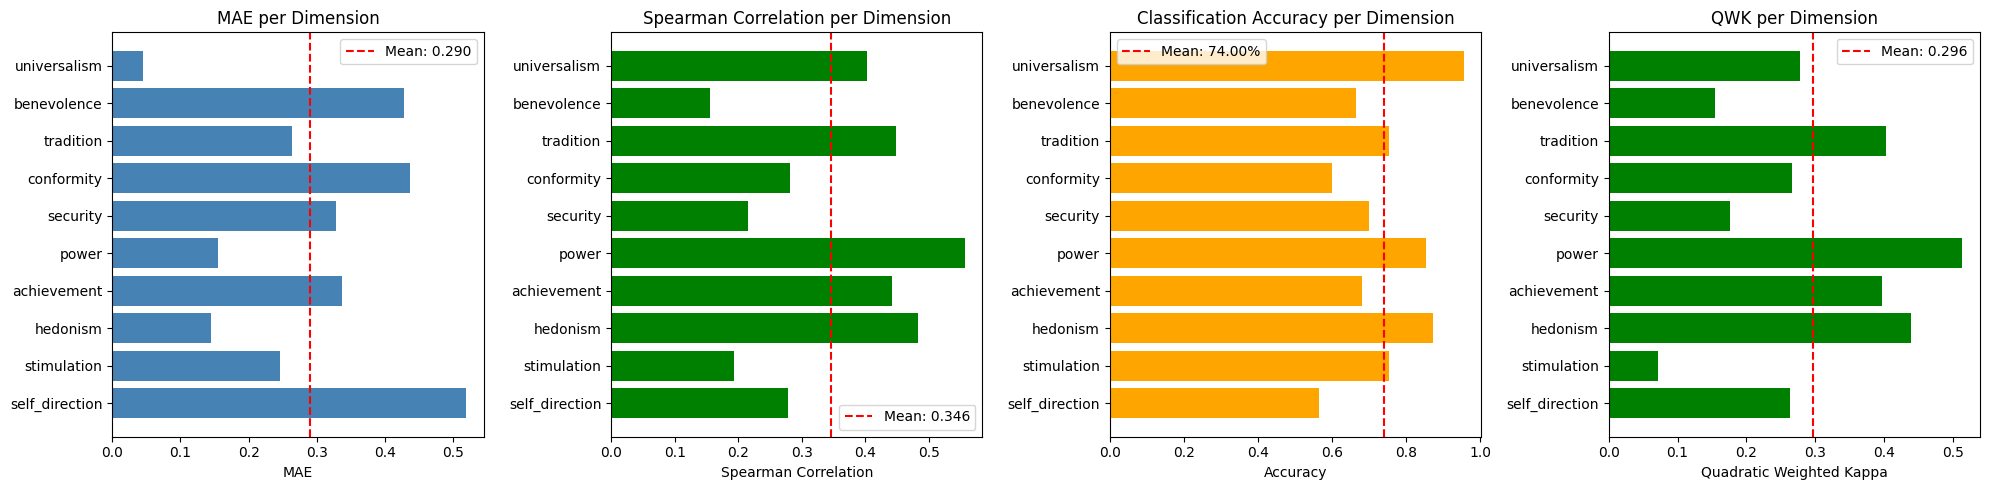

In [13]:
# Visualize per-dimension performance
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

dims = list(results["mae_per_dim"].keys())

mae_vals = list(results["mae_per_dim"].values())
axes[0].barh(dims, mae_vals, color="steelblue")
axes[0].set_xlabel("MAE")
axes[0].set_title("MAE per Dimension")
axes[0].axvline(results["mae_mean"], color="red", linestyle="--", label=f"Mean: {results['mae_mean']:.3f}")
axes[0].legend()

spearman_vals = [results["spearman_per_dim"][d] for d in dims]
colors = ["green" if v > 0 else "red" for v in spearman_vals]
axes[1].barh(dims, spearman_vals, color=colors)
axes[1].set_xlabel("Spearman Correlation")
axes[1].set_title("Spearman Correlation per Dimension")
axes[1].axvline(results["spearman_mean"], color="red", linestyle="--", label=f"Mean: {results['spearman_mean']:.3f}")
axes[1].legend()

acc_vals = [results["accuracy_per_dim"][d] for d in dims]
axes[2].barh(dims, acc_vals, color="orange")
axes[2].set_xlabel("Accuracy")
axes[2].set_title("Classification Accuracy per Dimension")
axes[2].axvline(results["accuracy_mean"], color="red", linestyle="--", label=f"Mean: {results['accuracy_mean']:.2%}")
axes[2].legend()

qwk_vals = [results["qwk_per_dim"][d] for d in dims]
qwk_colors = ["green" if v > 0 else "red" for v in qwk_vals]
axes[3].barh(dims, qwk_vals, color=qwk_colors)
axes[3].set_xlabel("Quadratic Weighted Kappa")
axes[3].set_title("QWK per Dimension")
axes[3].axvline(results["qwk_mean"], color="red", linestyle="--", label=f"Mean: {results['qwk_mean']:.3f}")
axes[3].legend()

plt.tight_layout()
plt.show()

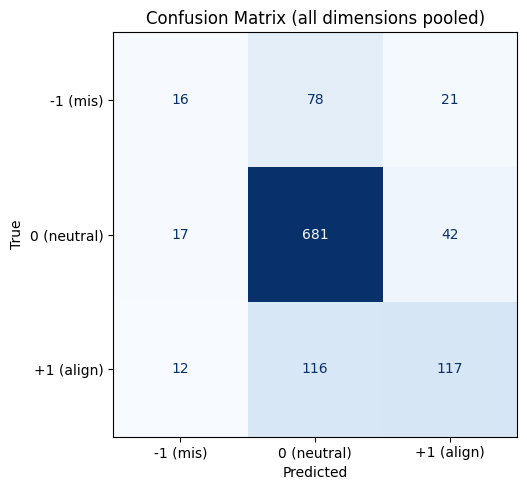

Class -1: 16/115 recall = 13.9%
Class +0: 681/740 recall = 92.0%
Class +1: 117/245 recall = 47.8%


In [14]:
# Confusion matrix (aggregated across all 10 dimensions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_flat = results["predictions"].flatten().astype(int)
target_flat = results["targets"].flatten().astype(int)

cm = confusion_matrix(target_flat, pred_flat, labels=[-1, 0, 1])

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=["-1 (mis)", "0 (neutral)", "+1 (align)"])
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (all dimensions pooled)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

for i, label in enumerate([-1, 0, 1]):
    row_total = cm[i].sum()
    correct = cm[i, i]
    recall = correct / row_total if row_total > 0 else 0
    print(f"Class {label:+d}: {correct}/{row_total} recall = {recall:.1%}")

## 5. Ablation Studies

Try different smoothing values.

In [15]:
# Ablation: compare smoothing values
# Uncomment to run

# smoothing_values = [0.05, 0.10, 0.15, 0.20, 0.30]
# ablation_results = {}
# for s in smoothing_values:
#     print(f'\n{"="*60}')
#     print(f'Testing smoothing={s}')
#     print('=' * 60)
#     # Re-train with different smoothing...
#     # ablation_results[s] = results

In [16]:
# Summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Encoder: {text_encoder.model_name}")
print(f"State dim: {state_encoder.state_dim}")
print(f"Model params: {n_params:,}")
print(f"Smoothing: {SMOOTHING}")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Test MAE: {results['mae_mean']:.4f}")
print(f"Test Spearman: {results['spearman_mean']:.4f}")
print(f"Test Accuracy: {results['accuracy_mean']:.2%}")
print(f"Test QWK: {results['qwk_mean']:.4f}")
print("=" * 60)


TRAINING SUMMARY
Encoder: all-MiniLM-L6-v2
State dim: 1174
Model params: 375,326
Smoothing: 0.15
Best val loss: 2.7838
Test MAE: 0.2900
Test Spearman: 0.3455
Test Accuracy: 74.00%
Test QWK: 0.2959


## 6. Notes: Soft Ordinal Labels

**How it works:**
- Convert hard labels {-1, 0, +1} to soft probability distributions
- Ordinal smoothing spreads probability mass to adjacent classes based on distance
- Train with KL divergence between predicted softmax and soft targets

**Example (smoothing=0.15):**
- Label -1 → [0.85, 0.15, 0.00] (most mass on correct class, some on neighbor)
- Label  0 → [0.13, 0.74, 0.13] (symmetric smoothing to both neighbors)
- Label +1 → [0.00, 0.15, 0.85]

**Advantages:**
- Simplest approach — no special loss function, just relabel targets
- Naturally encodes ordinal structure through the smoothing distribution
- Acts as regularization (prevents overconfident predictions)
- Smoothing parameter controls the strength of ordinal prior

**Trade-offs:**
- Requires tuning the smoothing hyperparameter
- Less theoretically grounded than CORN/CORAL for ordinal regression
- Standard classification output (3 logits) — more parameters than K-1 approaches